In [32]:
# Import libraries
import numpy as np
import pandas as pd
import cvxpy as cp

import os
from datetime import datetime

import matplotlib.pyplot as plt

The MVP maximizes: $$w’ \mu - \frac{\lambda}{2}w’ \sum w$$ subject to $1’w=1$ and $w \ge 0$, where $\lambda$ is a hyper-parameter that controls how risk averse the investor is. An idea would be to estimate $\lambda$ using a cross-validation dataset within the in-sample data. 

In [ ]:
def MVP_lmd(X_log, lmd=1):
    # Estimate mu and Sigma with training data
    mu = X_log.mean().values
    sigma = X_log.cov().values

    # Initialize variables and constraints
    N = len(sigma)
    weights = cp.Variable(N) # Vector variable "weights" of size N that will be optimized using train data. 
    constraints = [cp.sum(weights) == 1, weights >= 0] # Define capital budget, and long-only constraint

    prob = cp.Problem(cp.Maximize(mu @ weights - (lmd/2) * cp.quad_form(weights, sigma)), constraints) # Form the problem (formula above)
    prob.solve() # Find the optimal value of the problem above 
    return weights.value # Return a vector containing optimal weight allocations across the N assets

In [ ]:
def simple_backtest(prices, str_test, end_test):
    prices = prices.dropna(axis=1, how='any')

    # Calculate linear and logarithmic returns; Remove NaN to prevent errors
    X_lin = prices.pct_change().dropna()
    X_log = np.log1p(X_lin)
    
    # Define train and test data
    X_lin_test =  X_lin[str_test:end_test]
    X_log_trn = X_log[:str_test]

    # Design portfolio weights
    w_MVP = MVP_lmd(X_log_trn)

    # Backtest portfolios with test data
    ret_MVP = X_lin_test @ w_MVP

    # Compute cumulative returns
    cum_MVP = (1 + ret_MVP).cumprod() - 1

    return cum_MVP

In [35]:
# Initialize global variables
opt_dates = os.listdir("assets")
historical_data = pd.read_csv("historical_data.csv").set_index("Date")

start_idx = 0
end_idx = len(opt_dates)
lookback = 252

all_dates = list(historical_data.index)
all_dates = [ int(datetime.strptime(x, '%Y-%m-%d').strftime('%Y%m%d')) for x in all_dates ]

# Will cycle through the monthly constituents and backtest the portfolios with the available data
while start_idx < end_idx:
    # Load constituents and save ones we have price data for as "exst_consts"
    consts = pd.read_csv("assets\\" + opt_dates[start_idx]).set_index("rank")
    exst_consts = set(consts["ticker"]).intersection(historical_data.columns)
    exst_consts = historical_data[list(exst_consts)]

    # Obtain the train + test data by period
    str_test = datetime.strptime(opt_dates[start_idx][6:-4], '%Y%m%d').strftime('%Y-%m-%d') 
    end_test = datetime.strptime(opt_dates[start_idx + 1][6:-4], '%Y%m%d').strftime('%Y-%m-%d') 
    exst_data = current_holdings = exst_consts.loc[:end_test]

    cum_rets = simple_backtest(exst_data, str_test, end_test)
    break
    
 

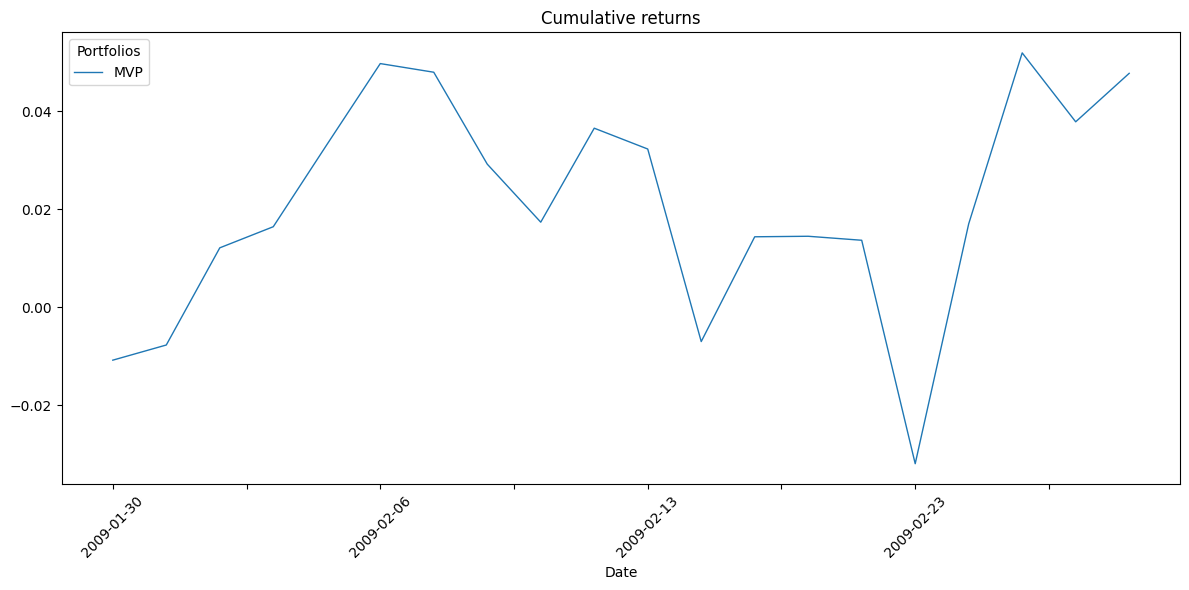

In [36]:
# Plot cumulative returns
plt.figure(figsize=(12, 6))
cum_rets.plot(label='MVP', linewidth=1)
plt.title('Cumulative returns')
plt.legend(title='Portfolios')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()